In [1]:
#installing fast.ai for deep learning models and gdown to download files from google drive
!pip install fastai
!pip install gdown

In [2]:
#importing necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
import zipfile
from google.colab import drive


In [3]:
#giving access to google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#training using CUDA instead of CPU because it is faster 
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Tue Apr 19 23:11:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

# Reading in Fashion Data

In [5]:
# getting the metadata from the drive connected to the DeepFashion database
url = 'https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp'
output = 'list_category_cloth.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ'
output = 'list_category_img.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx'
output = 'list_eval_partition.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 406kB/s]
Downloading...
From: https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ
To: /content/list_category_img.txt
100%|██████████| 21.4M/21.4M [00:00<00:00, 65.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx
To: /content/list_eval_partition.txt
100%|██████████| 22.2M/22.2M [00:00<00:00, 95.0MB/s]


'list_eval_partition.txt'

In [6]:
#extracting the images from the zip file downloaded fromm the DeepFashion Database 
root_path = "/content/"
zip_ref = zipfile.ZipFile("/content/gdrive/Shared drives/DATS6501 Capstone Group 1/Fashion Data/img.zip", 'r')
zip_ref.extractall(root_path)
zip_ref.close()

In [7]:
#setting the info from the metadata text files (image paths, clothing catagories, data type (train,val,test)) to lists 

category_list = []
image_path_list = []
data_type_list = []
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [8]:
#creating dataframe with the image path, clothing category, and data type of each image in the dataset
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


In [9]:
#getting the count of how the dataset is split 
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

,image_path
dataset_type,
test,40000
train,209222
val,40000


In [10]:
#getting the number of clothing categories
len(data_df.category.unique())

46

In [11]:
#getting the number of images for each clothing category 
data_df[['image_path','category']].groupby('category').count()

,image_path
category,
Anorak,160
Blazer,7495
Blouse,24557
Bomber,309
Button-Down,330
Caftan,54
Capris,77
Cardigan,13311
Chinos,527


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


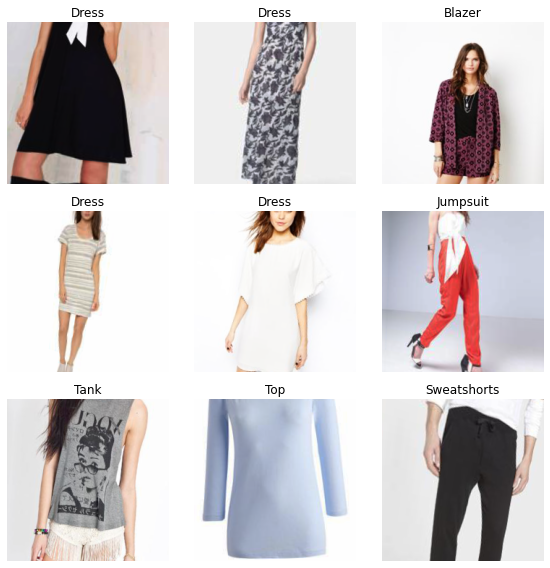

In [12]:
#creating the train and test image datasets 
train_images = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_images = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

#setting batch size, normalizing the data
data = train_images.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_images)
data.show_batch(rows=3, figsize=(8,8))

# **ResNet**

In [13]:
# defining function to call the pretrained ResNet model
def train_model(data, resnet_model, model_metrics):
    learner = cnn_learner(data, resnet_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

# ResNet18

In [14]:
#loading the pretrained model depending on number of layers
#resnet_model = models.resnet18

#get top 1 and top 10 accuracy
#model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]

#setting the learner using the train function from above 
#learner = train_model(data, resnet_model, model_metrics)

In [15]:
#learner.fit_one_cycle(15, max_lr=1e-02)

In [16]:
# saving the model results to results folder 
#drive.mount('/content/gdrive')
#learner.save('/content/gdrive/Shared drives/DATS6501 Capstone Group 1/Results/ResNet18-fashion')

# ResNet34

In [17]:
#loading the pretrained model depending on number of layers
#get top 1 and top 10 accuracy
#model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]

#setting the learner using the train function from above 
#learner = train_model(data, resnet_model, model_metrics)

In [18]:
#running the model
#learner.fit_one_cycle(15, max_lr=1e-02)

In [19]:
# saving the model results to results folder
#drive.mount('/content/gdrive')
#learner.save('/content/gdrive/Shared Drives/DATS6501 Capstone Group 1/Results/ResNet34-fashion')

# ResNet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.20E-02


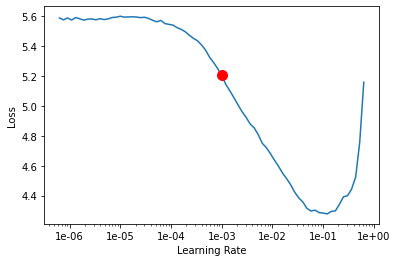

In [20]:
#loading the pretrained model depending on number of layers
resnet_model = models.resnet50
#get top 1 and top 10 accuracy
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]

#setting the learner using the train function from above 
learner = train_model(data, resnet_model, model_metrics)

In [21]:
#running the model
learner.fit_one_cycle(15, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.459084,1.319604,0.615950,0.615950,0.904450,36:15
1,1.418717,1.334911,0.611000,0.611000,0.899950,39:54
2,1.430607,1.370027,0.597875,0.597875,0.897625,39:50
3,1.417510,1.327050,0.606625,0.606625,0.903825,40:01
4,1.390174,1.312510,0.618125,0.618125,0.904875,40:10
5,1.362596,1.302541,0.617000,0.617000,0.905925,38:57
6,1.372553,1.245903,0.633925,0.633925,0.912975,34:41
7,1.341155,1.236134,0.637925,0.637925,0.914150,34:41
8,1.303328,1.195143,0.648400,0.648400,0.918975,34:37
9,1.281804,1.166840,0.658225,0.658225,0.923550,34:37
